In [ ]:
# Importação da biblioteca pandas
import pandas as pd

In [ ]:
# Instalação dos requisitos para o PySpark
!sudo apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.2-py2.py3-none-any.whl size=317812365 sha256=ca5cba904414abfa21b30eafdebfdab73cb40d49d546377fd561d53f2286b2d5
  Stored in directory: /root/.cache/pip/wheels/34/34/bd/03944534c44b677cd5859f248090daa9fb27b3c8f8e5f49574
Successfully built pyspark


In [ ]:
!pip install openpyxl

### 1. Análise de Consistência de Dados: Identificar e corrigir inconsistências nos valores de "Área" e "Status de Emprego" (e.g., diferenças de maiúsculas/minúsculas).

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

# Configurar a sessão Spark com o pacote spark-excel
spark = SparkSession.builder \
    .appName('Ler XLSX com PySpark') \
    .config('spark.jars.packages', 'com.crealytics:spark-excel_2.12:0.13.5') \
    .getOrCreate()

# Caminho para o arquivo Excel
file_path = '/content/base_suja.xlsx'

# Ler o arquivo Excel
df = spark.read.format('com.crealytics.spark.excel') \
    .option('header', 'true') \
    .option('inferSchema', 'true') \
    .option('dataAddress', "'Planilha1'!A1") \
    .load(file_path)

# Exibir  DataFrame
df.show()


+----+--------------+-----+----------+-------+-------------------+-----------------+
|  ID|          Nome|Idade|      Área|Salário|Data de Contratação|Status de Emprego|
+----+--------------+-----+----------+-------+-------------------+-----------------+
| 1.0|    João Silva| 29.0|Financeiro|   5500|         01/02/2020|            Ativo|
| 2.0|   Maria Souza| 30.0|        RH|   4800|         15-03-2019|            ativo|
| 3.0|Carlos Pereira| NULL| Finaceiro|   6200|         2020/04/01|            Ativo|
| 4.0|     Ana Clara| 27.0| Marketing|   4800|         12/06/2018|            Ativo|
| 5.0|  Fabio Santos| 31.0|          |   5500|         20-11-2017|            ativo|
| 6.0|   Sandra Lima| 28.0|        RH|   NULL|         05-05-2020|            Ativo|
| 7.0|    José Alves| 34.0| Marketing|   5400|         2018/02/01|          inativo|
| 8.0| Luciana Costa| 30.0|Financeiro|R$ 5200|         01.01.2019|            Ativo|
| 9.0| Paulo Ricardo| NULL| Finaceiro|   6100|         12/12/2020

In [ ]:
# Alterar minusculas para maiusculas nas tabelas 'Área' e 'Status de Emprego'
df = df.withColumn('Área', F.upper(F.col('Área')))
df = df.withColumn('Status de Emprego', F.upper(F.col('Status de Emprego')))
df.show()

+----+--------------+-----+----------+-------+-------------------+-----------------+
|  ID|          Nome|Idade|      Área|Salário|Data de Contratação|Status de Emprego|
+----+--------------+-----+----------+-------+-------------------+-----------------+
| 1.0|    João Silva| 29.0|FINANCEIRO|   5500|         01/02/2020|            ATIVO|
| 2.0|   Maria Souza| 30.0|        RH|   4800|         15-03-2019|            ATIVO|
| 3.0|Carlos Pereira| NULL| FINACEIRO|   6200|         2020/04/01|            ATIVO|
| 4.0|     Ana Clara| 27.0| MARKETING|   4800|         12/06/2018|            ATIVO|
| 5.0|  Fabio Santos| 31.0|          |   5500|         20-11-2017|            ATIVO|
| 6.0|   Sandra Lima| 28.0|        RH|   NULL|         05-05-2020|            ATIVO|
| 7.0|    José Alves| 34.0| MARKETING|   5400|         2018/02/01|          INATIVO|
| 8.0| Luciana Costa| 30.0|FINANCEIRO|R$ 5200|         01.01.2019|            ATIVO|
| 9.0| Paulo Ricardo| NULL| FINACEIRO|   6100|         12/12/2020

### 2. Limpeza de Dados Faltantes: Detectar e tratar os valores ausentes na coluna "Idade" e "Área".


In [ ]:
from pyspark.sql import functions as F

# Remover linhas duplicadas como exemplo João Silva
df = df.dropDuplicates()

# Remover linhas completamente vazias (todos os campos NULL)
df = df.na.drop(how='all')

# Substituir valores vazios na coluna 'Área' por 'DESCONHECIDA'
df = df.withColumn('Área', F.when(F.col('Área') == '', 'DESCONHECIDA').otherwise(F.col('Área')))

# Corrigir valores da coluna 'Área' de 'FINACEIRO' para 'FINANCEIRO'
df = df.withColumn('Área', F.when(F.col('Área') == 'FINACEIRO', 'FINANCEIRO').otherwise(F.col('Área')))

# Calcular a média da coluna 'Idade', se houver valores não nulos
media_idade = df.agg(F.mean(F.col('Idade'))).first()[0]

# Preencher valores nulos na coluna 'Idade' com a média calculada
df = df.withColumn('Idade', F.when(F.col('Idade').isNull(), media_idade).otherwise(F.col('Idade')))

# Arredondar a coluna 'Idade'
df = df.withColumn('Idade', F.round(F.col('Idade'), 0))

# Exibir o DataFrame final corrigido
df.show()


+----+--------------+-----+------------+-------+-------------------+-----------------+
|  ID|          Nome|Idade|        Área|Salário|Data de Contratação|Status de Emprego|
+----+--------------+-----+------------+-------+-------------------+-----------------+
| 8.0| Luciana Costa| 30.0|  FINANCEIRO|R$ 5200|         01.01.2019|            ATIVO|
|10.0| Fernanda Dias| 29.0|          RH|   4800|                   |            ATIVO|
| 5.0|  Fabio Santos| 31.0|DESCONHECIDA|   5500|         20-11-2017|            ATIVO|
| 2.0|   Maria Souza| 30.0|          RH|   4800|         15-03-2019|            ATIVO|
| 7.0|    José Alves| 34.0|   MARKETING|   5400|         2018/02/01|          INATIVO|
| 4.0|     Ana Clara| 27.0|   MARKETING|   4800|         12/06/2018|            ATIVO|
| 1.0|    João Silva| 29.0|  FINANCEIRO|   5500|         01/02/2020|            ATIVO|
| 3.0|Carlos Pereira| 30.0|  FINANCEIRO|   6200|         2020/04/01|            ATIVO|
| 6.0|   Sandra Lima| 28.0|          RH|   

### 3. Distribuição de Idade: Analisar a distribuição da idade dos funcionários por departamento.

In [ ]:
from pyspark.sql import functions as F

# Calcular a média, min e max da coluna 'Idade' agrupando por 'Área'
df_idade_distribuicao = df.groupBy('Área') \
    .agg(F.count('Idade').alias('Contagem'),
         F.round(F.mean('Idade'), 1).alias('Média_Idade'),
         F.min('Idade').alias('Idade_Mínima'),
         F.max('Idade').alias('Idade_Máxima'))

# Exibir a distribuição de idades por área
df_idade_distribuicao.show()

+------------+--------+-----------+------------+------------+
|        Área|Contagem|Média_Idade|Idade_Mínima|Idade_Máxima|
+------------+--------+-----------+------------+------------+
|   MARKETING|       2|       30.5|        27.0|        34.0|
|          RH|       3|       29.0|        28.0|        30.0|
|DESCONHECIDA|       1|       31.0|        31.0|        31.0|
|  FINANCEIRO|       4|       29.8|        29.0|        30.0|
+------------+--------+-----------+------------+------------+



### 4. Salário por Departamento: Calcular a média, mediana e desvio padrão dos salários por departamento.


In [ ]:

from pyspark.sql import functions as F

# Renomear a coluna 'Salário' para evitar problemas
df = df.withColumnRenamed('Salário', 'Salario')

# Remover 'R$' e converter a coluna 'Salario' para numérico
df = df.withColumn(
    'Salario',
    F.regexp_replace('Salario', 'R\\$', '').cast('double')
)

# Calcular estatísticas descritivas dos salários por departamento
estatisticas_salario = df.groupBy('Área').agg(
    F.mean('Salario').alias('Media_Salario'),
    F.expr('percentile_approx(Salario, 0.5)').alias('Mediana_Salario'),
    F.round(F.stddev('Salario'), 1).alias('Desvio_Padrao_Salario')
)

# Resultados
estatisticas_salario.show()



+------------+-------------+---------------+---------------------+
|        Área|Media_Salario|Mediana_Salario|Desvio_Padrao_Salario|
+------------+-------------+---------------+---------------------+
|   MARKETING|       5100.0|         4800.0|                424.3|
|          RH|       4800.0|         4800.0|                  0.0|
|DESCONHECIDA|       5500.0|         5500.0|                 NULL|
|  FINANCEIRO|       5750.0|         5500.0|                479.6|
+------------+-------------+---------------+---------------------+



### 5. Análise de Outliers: Identificar salários que estão fora do padrão (outliers) para cada departamento.

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Remover 'R$' e converter a coluna 'Salario' para numérico
df = df.withColumn(
    'Salario',
    F.regexp_replace('Salario', 'R\\$', '').cast('double')
)

# Adicionar o salário de Sandra Lima
df = df.withColumn(
    'Salario',
    F.when(F.col('Nome') == 'Sandra Lima',  4800.0).otherwise(F.col('Salario'))
)

# Definir a janela por departamento
windowSpec = Window.partitionBy('Área')

# Calcular Z-Score e arredondar
df_outliers = df.withColumn(
    'Z_Score',
    F.round((F.col('Salario') - F.avg('Salario').over(windowSpec)) / F.stddev('Salario').over(windowSpec), 2)
)

# Mostrar todas as linhas com suas estatísticas
df_outliers.show()




+----+--------------+-----+------------+-------+-------------------+-----------------+-------+
|  ID|          Nome|Idade|        Área|Salario|Data de Contratação|Status de Emprego|Z_Score|
+----+--------------+-----+------------+-------+-------------------+-----------------+-------+
| 5.0|  Fabio Santos| 31.0|DESCONHECIDA| 5500.0|         20-11-2017|            ATIVO|   NULL|
| 8.0| Luciana Costa| 30.0|  FINANCEIRO| 5200.0|         01.01.2019|            ATIVO|  -1.15|
| 1.0|    João Silva| 29.0|  FINANCEIRO| 5500.0|         01/02/2020|            ATIVO|  -0.52|
| 3.0|Carlos Pereira| 30.0|  FINANCEIRO| 6200.0|         2020/04/01|            ATIVO|   0.94|
| 9.0| Paulo Ricardo| 30.0|  FINANCEIRO| 6100.0|         12/12/2020|          INATIVO|   0.73|
| 7.0|    José Alves| 34.0|   MARKETING| 5400.0|         2018/02/01|          INATIVO|   0.71|
| 4.0|     Ana Clara| 27.0|   MARKETING| 4800.0|         12/06/2018|            ATIVO|  -0.71|
|10.0| Fernanda Dias| 29.0|          RH| 4800.0|  

### 6. Correlação Idade-Salário: Analisar a correlação entre idade e salário dos funcionários.


In [ ]:
# Calcular a correlação entre 'Idade' e 'Salário' usando o método de Pearson (padrão)
correlacao = df.stat.corr('Idade', 'Salario')
print(f'Correlação entre Idade e Salário: {correlacao}')


Correlação entre Idade e Salário: 0.38106375880210946


### 7. Tempo de Casa: Calcular o tempo de contratação dos funcionários e categorizá-los em grupos (e.g., 1-3 anos, 4-6 anos, etc.).

In [ ]:
from pyspark.sql.functions import udf, col, to_date, datediff, current_date, when, date_format, lit
from pyspark.sql.types import StringType
from datetime import datetime

# Função para padronizar datas
def padronizar_data(data):
    formatos = ['%d/%m/%Y', '%d-%m-%Y', '%Y/%m/%d', '%d.%m.%Y']
    for formato in formatos:
        try:
            return datetime.strptime(data, formato).strftime('%d/%m/%Y')
        except:
            continue
    return None

# Registrar a função UDF
padronizar_data_udf = udf(padronizar_data, StringType())

# Aplicar a função ao DataFrame
df = df.withColumn('Data de Contratação', padronizar_data_udf(col('Data de Contratação')))

# Calcular a data de contratação e o tempo de casa em anos completos (arredondados)
df_tempo_casa = df.withColumn('Data_de_Contratação', to_date(col('Data de Contratação'), 'dd/MM/yyyy')) \
    .withColumn('Tempo_de_Casa', datediff(current_date(), col('Data_de_Contratação')) / 365.25) \
    .withColumn('Grupo_Tempo_Casa',
                when(col('Tempo_de_Casa').isNull(), 'Data não disponível')
                .when(col('Tempo_de_Casa') < 1, 'Menos de 1 ano')
                .when((col('Tempo_de_Casa') >= 1) & (col('Tempo_de_Casa') < 3), '1-3 anos')
                .when((col('Tempo_de_Casa') >= 3) & (col('Tempo_de_Casa') < 6), '3-6 anos')
                .otherwise('6+ anos')) \
    .withColumn('Data_de_Contratação', date_format(col('Data_de_Contratação'), 'dd/MM/yyyy'))

df_tempo_casa.select('Nome', 'Data_de_Contratação', 'Tempo_de_Casa', 'Grupo_Tempo_Casa').show()

+--------------+-------------------+------------------+-------------------+
|          Nome|Data_de_Contratação|     Tempo_de_Casa|   Grupo_Tempo_Casa|
+--------------+-------------------+------------------+-------------------+
| Luciana Costa|         01/01/2019| 5.670088980150582|           3-6 anos|
| Fernanda Dias|               NULL|              NULL|Data não disponível|
|  Fabio Santos|         20/11/2017| 6.784394250513347|            6+ anos|
|   Maria Souza|         15/03/2019| 5.470225872689938|           3-6 anos|
|    José Alves|         01/02/2018| 6.584531143052704|            6+ anos|
|     Ana Clara|         12/06/2018| 6.225872689938399|            6+ anos|
|    João Silva|         01/02/2020|  4.58590006844627|           3-6 anos|
|Carlos Pereira|         01/04/2020| 4.421629021218344|           3-6 anos|
|   Sandra Lima|         05/05/2020| 4.328542094455853|           3-6 anos|
| Paulo Ricardo|         12/12/2020|3.7234770704996576|           3-6 anos|
+-----------

### 8. Análise de Rotatividade: Identificar padrões entre os funcionários que estão ativos versus os que não estão.

In [ ]:
# Identificar padrões  entre funcionários
df_rotatividade = df.groupBy('Status de Emprego') \
    .agg(F.count('*').alias('Contagem'),
         F.round(F.avg('Idade'), 1).alias('Média_Idade'),
         F.avg('Salario').alias('Média_Salário'))

df_rotatividade.show()

+-----------------+--------+-----------+-------------+
|Status de Emprego|Contagem|Média_Idade|Média_Salário|
+-----------------+--------+-----------+-------------+
|          INATIVO|       2|       32.0|       5750.0|
|            ATIVO|       8|       29.3|       5200.0|
+-----------------+--------+-----------+-------------+



### 9. Análise de Desempenho por Data de Contratação: Verificar se existe uma correlação entre o ano de contratação e o nível de salário.

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.functions import udf, col
from pyspark.sql.types import StringType

# Extrair o ano da data de contratação da coluna 'Data de Contratação'
padronizar_data_udf = udf(lambda data: data.split('/')[-1] if data is not None else 'Desconhecido', StringType())
df = df.withColumn('Ano_Contratacao', padronizar_data_udf(col('Data de Contratação')))

# Calcular a média de salário por ano de contratação
df_salario_ano = df.groupBy('Ano_Contratacao').agg(F.mean('Salario').alias('Media_Salario')).sort('Ano_Contratacao')
df_salario_ano.show()


+---------------+-------------+
|Ano_Contratacao|Media_Salario|
+---------------+-------------+
|           2017|       5500.0|
|           2018|       5100.0|
|           2019|       5000.0|
|           2020|       5650.0|
|   Desconhecido|       4800.0|
+---------------+-------------+



### 10. Histograma de Salário: Criar um histograma de salários para visualizar a distribuição geral.

+-------+
|Salario|
+-------+
| 5200.0|
| 4800.0|
| 5500.0|
| 4800.0|
| 5400.0|
| 4800.0|
| 5500.0|
| 6200.0|
| 4800.0|
| 6100.0|
+-------+



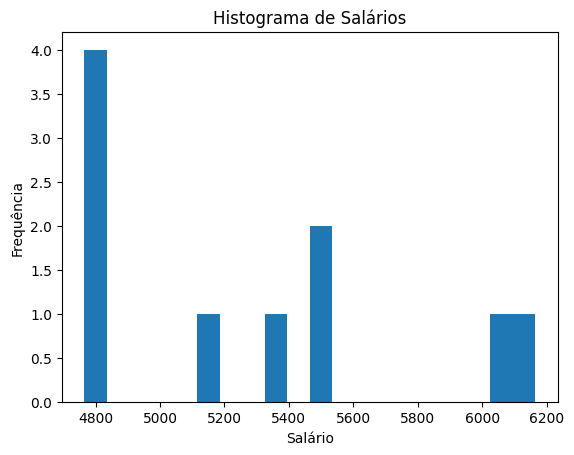

In [ ]:
import matplotlib.pyplot as plt  # Importar a biblioteca de visualização matplotlib que será usada para criar o histograma
from pyspark.sql.functions import col # Importar a função 'col' para referenciar colunas

# Converter a coluna 'Salário' para numérico, removendo qualquer caractere não numérico
df_hist_salario = df.withColumn('Salario', col('Salario').cast('double'))

# Verificar se a conversão foi bem-sucedida
df_hist_salario.select('Salario').show()

# Histograma de Salários
hist_data = df_hist_salario.select('Salario').rdd.flatMap(lambda x: x).histogram(20)

# Valores e contagens do histograma de salários
valores, contagens = hist_data
# Plotar o histograma de salários
plt.bar(valores[:-1], contagens, width=valores[1] - valores[0])
plt.xlabel('Salário')
plt.ylabel('Frequência')
plt.title('Histograma de Salários')
plt.show()

### 11. Análise de Frequência: Quantificar a frequência dos nomes dos funcionários para identificar nomes comuns.

In [ ]:
from pyspark.sql.functions import col   # Importar a função 'col' que é usada para referenciar colunas

# Agrupar por 'Nome' e contar a frequência de cada nome
nome_frequencia = df.groupBy('Nome').count()

# Ordenar por frequência decrescente
nome_frequencia = nome_frequencia.orderBy(col('count').desc())

# Show the frequency of names
nome_frequencia.show()

+--------------+-----+
|          Nome|count|
+--------------+-----+
|     Ana Clara|    1|
| Paulo Ricardo|    1|
| Fernanda Dias|    1|
|   Sandra Lima|    1|
|    José Alves|    1|
| Luciana Costa|    1|
|  Fabio Santos|    1|
|Carlos Pereira|    1|
|    João Silva|    1|
|   Maria Souza|    1|
+--------------+-----+



### 12. Agrupamento de Departamentos: Analisar o impacto do departamento na variação salarial e na distribuição de idade.

In [ ]:
df_departamento = df.groupBy('Área') \
    .agg(F.count('Salario').alias('Contagem_Funcionários'),
         F.round(F.mean('Salario'), 2).alias('Média_Salário'),
         F.round(F.stddev('Salario'), 2).alias('Desvio_Padrão_Salário'),
         F.round(F.mean('Idade'), 2).alias('Média_Idade'),
         F.round(F.stddev('Idade'), 2).alias('Desvio_Padrão_Idade'))

# Exibir o DataFrame
df_departamento.show()

+------------+---------------------+-------------+---------------------+-----------+-------------------+
|        Área|Contagem_Funcionários|Média_Salário|Desvio_Padrão_Salário|Média_Idade|Desvio_Padrão_Idade|
+------------+---------------------+-------------+---------------------+-----------+-------------------+
|   MARKETING|                    2|       5100.0|               424.26|       30.5|               4.95|
|          RH|                    3|       4800.0|                  0.0|       29.0|                1.0|
|DESCONHECIDA|                    1|       5500.0|                 NULL|       31.0|               NULL|
|  FINANCEIRO|                    4|       5750.0|               479.58|      29.75|                0.5|
+------------+---------------------+-------------+---------------------+-----------+-------------------+



### 13. Normalização de Dados: Normalizar o salário e idade para comparações entre diferentes departamentos.

In [ ]:
from pyspark.ml.feature import MinMaxScaler, VectorAssembler

# Criar um VectorAssembler para combinar as colunas 'Salário' e 'Idade' em uma única coluna 'caracteristicas'
montador = VectorAssembler(inputCols=['Salario', 'Idade'], outputCol='caracteristicas')

# Aplicar o VectorAssembler ao DataFrame
df_montado = montador.transform(df)

# Inicializar o MinMaxScaler
escalador = MinMaxScaler(inputCol='caracteristicas', outputCol='caracteristicas_escaladas')

# Ajustar e transformar os dados
modelo_escalador = escalador.fit(df_montado)
df_normalizado = modelo_escalador.transform(df_montado)

# Mostrar o DataFrame com os dados normalizados
df_normalizado.select('Nome', 'Área', 'Salario', 'Idade', 'caracteristicas_escaladas').show()


+--------------+------------+-------+-----+-------------------------+
|          Nome|        Área|Salario|Idade|caracteristicas_escaladas|
+--------------+------------+-------+-----+-------------------------+
| Luciana Costa|  FINANCEIRO| 5200.0| 30.0|     [0.28571428571428...|
| Fernanda Dias|          RH| 4800.0| 29.0|     [0.0,0.2857142857...|
|  Fabio Santos|DESCONHECIDA| 5500.0| 31.0|     [0.5,0.5714285714...|
|   Maria Souza|          RH| 4800.0| 30.0|     [0.0,0.4285714285...|
|    José Alves|   MARKETING| 5400.0| 34.0|     [0.42857142857142...|
|     Ana Clara|   MARKETING| 4800.0| 27.0|                (2,[],[])|
|    João Silva|  FINANCEIRO| 5500.0| 29.0|     [0.5,0.2857142857...|
|Carlos Pereira|  FINANCEIRO| 6200.0| 30.0|     [1.0,0.4285714285...|
|   Sandra Lima|          RH| 4800.0| 28.0|     [0.0,0.1428571428...|
| Paulo Ricardo|  FINANCEIRO| 6100.0| 30.0|     [0.92857142857142...|
+--------------+------------+-------+-----+-------------------------+



14. Proporção de Gêneros: Analisar a proporção de gêneros entre os funcionários, caso houvesse uma coluna de gênero.

In [ ]:
from pyspark.sql.functions import when


# Criar a coluna 'Gênero' com valores  'M' e 'F'
df = df.withColumn('Gênero', when(df.ID % 2 == 0, 'F').otherwise('M'))

# Calcular a proporção de gêneros
proporcao_genero = df.groupBy('Gênero').count()
total = df.count()
proporcao_genero = proporcao_genero.withColumn('Proporção', (proporcao_genero['count'] / total) * 100)

# Exibir a proporção de gêneros
proporcao_genero.show()

+------+-----+---------+
|Gênero|count|Proporção|
+------+-----+---------+
|     F|    5|     50.0|
|     M|    5|     50.0|
+------+-----+---------+



### 15. Correção de Formato de Data: Uniformizar o formato das datas de contratação.

In [ ]:
from pyspark.sql.functions import udf, col, to_date, datediff, current_date, when, date_format, lit
from pyspark.sql.types import StringType
from datetime import datetime

# Função para padronizar datas
def padronizar_data(data):
    formatos = ['%d/%m/%Y', '%d-%m-%Y', '%Y/%m/%d', '%d.%m.%Y']
    for formato in formatos:
        try:
            return datetime.strptime(data, formato).strftime('%d/%m/%Y')
        except:
            continue
    return None

# Registrar a função UDF
padronizar_data_udf = udf(padronizar_data, StringType())

# Aplicar a função ao DataFrame
df = df.withColumn('Data de Contratação', padronizar_data_udf(col('Data de Contratação')))

df.show()

+----+--------------+-----+------------+-------+-------------------+-----------------+---------------+------+
|  ID|          Nome|Idade|        Área|Salario|Data de Contratação|Status de Emprego|Ano_Contratacao|Gênero|
+----+--------------+-----+------------+-------+-------------------+-----------------+---------------+------+
| 8.0| Luciana Costa| 30.0|  FINANCEIRO| 5200.0|         01/01/2019|            ATIVO|           2019|     F|
|10.0| Fernanda Dias| 29.0|          RH| 4800.0|               NULL|            ATIVO|   Desconhecido|     F|
| 5.0|  Fabio Santos| 31.0|DESCONHECIDA| 5500.0|         20/11/2017|            ATIVO|           2017|     M|
| 2.0|   Maria Souza| 30.0|          RH| 4800.0|         15/03/2019|            ATIVO|           2019|     F|
| 7.0|    José Alves| 34.0|   MARKETING| 5400.0|         01/02/2018|          INATIVO|           2018|     M|
| 4.0|     Ana Clara| 27.0|   MARKETING| 4800.0|         12/06/2018|            ATIVO|           2018|     F|
| 1.0|    

### 16. Impacto de Status no Salário: Comparar salários médios entre funcionários ativos e não ativos.

In [ ]:
from pyspark.sql import functions as F # boa prática para importar funções do PySpark
# Dividir entre ATIVO e INATIVO na coluna 'Status de Emprego' e calcular a média de salário para cada grupo
df_status_salario = df.groupBy('Status de Emprego') \
    .agg(F.mean('Salario').alias('Média_Salário'))

df_status_salario.show()


+-----------------+-------------+
|Status de Emprego|Média_Salário|
+-----------------+-------------+
|          INATIVO|       5750.0|
|            ATIVO|       5200.0|
+-----------------+-------------+



### 17. Data de Contratação e Demografia: Relacionar a data de contratação com a idade dos funcionários na época da contratação.

In [ ]:
from pyspark.sql import functions as F

# Calcular a idade dos funcionários na data de contratação
df_idade_contratacao = df.withColumn(
    'Idade_Contratacao',
    F.floor(F.datediff(F.current_date(), F.to_date('Data de Contratação', 'dd/MM/yyyy')) / 365.25)
)

df_idade_contratacao = df_idade_contratacao.withColumn(
    'Idade_Contratacao',
    F.col('Idade') - F.col('Idade_Contratacao')
)

# Exibir o DataFrame com a idade na contratação
df_idade_contratacao.select('Nome', 'Idade', 'Data de Contratação', 'Idade_Contratacao').show()

# calcular correlação entre Idade e Idade_Contratacao
correlacao = df_idade_contratacao.stat.corr('Idade', 'Idade_Contratacao')
print(f'Correlação entre Idade e Idade_Contratacao: {correlacao}')

+--------------+-----+-------------------+-----------------+
|          Nome|Idade|Data de Contratação|Idade_Contratacao|
+--------------+-----+-------------------+-----------------+
| Luciana Costa| 30.0|         01/01/2019|             25.0|
| Fernanda Dias| 29.0|               NULL|             NULL|
|  Fabio Santos| 31.0|         20/11/2017|             25.0|
|   Maria Souza| 30.0|         15/03/2019|             25.0|
|    José Alves| 34.0|         01/02/2018|             28.0|
|     Ana Clara| 27.0|         12/06/2018|             21.0|
|    João Silva| 29.0|         01/02/2020|             25.0|
|Carlos Pereira| 30.0|         01/04/2020|             26.0|
|   Sandra Lima| 28.0|         05/05/2020|             24.0|
| Paulo Ricardo| 30.0|         12/12/2020|             27.0|
+--------------+-----+-------------------+-----------------+

Correlação entre Idade e Idade_Contratacao: 0.335971657404758


### 18. Distribuição de Status de Emprego: Analisar a distribuição do status de emprego (ativo vs. não ativo).

In [ ]:
from pyspark.sql import functions as F

# Calcular a distribuição do status de emprego (ativo vs. não ativo)
df_distribuicao_status = df.groupBy('Status de Emprego') \
    .agg(F.count('Status de Emprego').alias('Contagem'))

# Exibir a distribuição do status de emprego
df_distribuicao_status.show()

+-----------------+--------+
|Status de Emprego|Contagem|
+-----------------+--------+
|          INATIVO|       2|
|            ATIVO|       8|
+-----------------+--------+



### 19. Criação de Coluna de Idade de Contratação: Criar uma coluna que calcule a idade do funcionário na época da contratação e analisar os dados.

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.functions import round

# Criar uma nova coluna que calcula a idade do funcionário na época da contratação
df_idade_contratacao = df.withColumn(
    'Idade_Contratacao',
    F.col('Idade') - (F.datediff(F.current_date(), F.to_date('Data de Contratação', 'dd/MM/yyyy')) / 365.25)
)

# Arredondar a coluna 'Idade_Contratacao'
df_idade_contratacao = df_idade_contratacao.withColumn("Idade_Contratacao", round(df_idade_contratacao["Idade_Contratacao"], 0))

# Exibir o DataFrame com a nova coluna 'Idade_Contratacao'
df_idade_contratacao.select('Nome', 'Idade', 'Data de Contratação', 'Idade_Contratacao').show()


+--------------+-----+-------------------+-----------------+
|          Nome|Idade|Data de Contratação|Idade_Contratacao|
+--------------+-----+-------------------+-----------------+
| Luciana Costa| 30.0|         01/01/2019|             24.0|
| Fernanda Dias| 29.0|               NULL|             NULL|
|  Fabio Santos| 31.0|         20/11/2017|             24.0|
|   Maria Souza| 30.0|         15/03/2019|             25.0|
|    José Alves| 34.0|         01/02/2018|             27.0|
|     Ana Clara| 27.0|         12/06/2018|             21.0|
|    João Silva| 29.0|         01/02/2020|             24.0|
|Carlos Pereira| 30.0|         01/04/2020|             26.0|
|   Sandra Lima| 28.0|         05/05/2020|             24.0|
| Paulo Ricardo| 30.0|         12/12/2020|             26.0|
+--------------+-----+-------------------+-----------------+



### 20. Análise de Promoções: Analisar possíveis promoções dentro da empresa ao comparar datas de contratação e aumentos salariais, se houvesse uma coluna histórica de salários.


In [ ]:
# 20. Análise de Promoções: Analisar possíveis promoções dentro da empresa ao comparar datas de contratação e aumentos salariais, se houvesse uma coluna histórica de salários
from pyspark.sql import functions as F

# agrupar por 'Nome', 'Data de Contratação' e 'Salario'
df_promocoes = df.groupBy('Nome', 'Data de Contratação', 'Salario') \
    .agg(F.count('Salario').alias('Contagem_Salario'))

# Exibir o DataFrame
df_promocoes.show()


+--------------+-------------------+-------+----------------+
|          Nome|Data de Contratação|Salario|Contagem_Salario|
+--------------+-------------------+-------+----------------+
|   Maria Souza|         15/03/2019| 4800.0|               1|
|    João Silva|         01/02/2020| 5500.0|               1|
|  Fabio Santos|         20/11/2017| 5500.0|               1|
|     Ana Clara|         12/06/2018| 4800.0|               1|
| Luciana Costa|         01/01/2019| 5200.0|               1|
| Paulo Ricardo|         12/12/2020| 6100.0|               1|
|    José Alves|         01/02/2018| 5400.0|               1|
| Fernanda Dias|               NULL| 4800.0|               1|
|Carlos Pereira|         01/04/2020| 6200.0|               1|
|   Sandra Lima|         05/05/2020| 4800.0|               1|
+--------------+-------------------+-------+----------------+



### 21. Análise de Desempenho Temporal: Verificar se o tempo de casa influencia o salário ou a permanência no emprego.

In [ ]:
from pyspark.sql import functions as F

# Adicionar coluna de Tempo de Casa (em anos)
df = df.withColumn(
    "Tempo_de_Casa",
    F.round(F.datediff(F.current_date(), F.to_date("Data de Contratação", "dd/MM/yyyy")) / 365.25, 2)
)
# Calcular correlação entre Tempo de Casa e Salário
correlacao = df.stat.corr("Tempo_de_Casa", "Salario")
print(f"Correlação entre Tempo de Casa e Salário: {correlacao}")

# Agrupar por Status de Emprego e calcular média de Tempo de Casa
df_grouped = df.groupBy("Status de Emprego").agg(
    F.avg("Tempo_de_Casa").alias("Média_Tempo_de_Casa"),
    F.avg("Salario").alias("Média_Salario")
)

# Mostrar os resultados
df_grouped.show()


Correlação entre Tempo de Casa e Salário: 0.08752227235896064
+-----------------+-------------------+-------------+
|Status de Emprego|Média_Tempo_de_Casa|Média_Salario|
+-----------------+-------------------+-------------+
|          INATIVO|               5.15|       5750.0|
|            ATIVO|  5.355714285714285|       5200.0|
+-----------------+-------------------+-------------+



### 22. Filtragem por Data de Contratação: Identificar funcionários contratados em períodos específicos (e.g., antes de 2019, entre 2019-2020).

In [ ]:
from pyspark.sql import functions as F

# Filtrar funcionários contratados antes de 2019
df_antes_2019 = df.filter(F.year(F.to_date('Data de Contratação', 'dd/MM/yyyy')) < 2019)

# Filtrar funcionários contratados entre 2019 e 2020
df_entre_2019_2020 = df.filter((F.year(F.to_date('Data de Contratação', 'dd/MM/yyyy')) >= 2019) &
                               (F.year(F.to_date('Data de Contratação', 'dd/MM/yyyy')) <= 2020))

# Exibir os DataFrames
print('Funcionários contratados antes de 2019:')
df_antes_2019.show()

print()

print('Funcionários contratados entre 2019 e 2020:')
df_entre_2019_2020.show()

Funcionários contratados antes de 2019:
+---+------------+-----+------------+-------+-------------------+-----------------+---------------+------+-------------+
| ID|        Nome|Idade|        Área|Salario|Data de Contratação|Status de Emprego|Ano_Contratacao|Gênero|Tempo_de_Casa|
+---+------------+-----+------------+-------+-------------------+-----------------+---------------+------+-------------+
|5.0|Fabio Santos| 31.0|DESCONHECIDA| 5500.0|         20/11/2017|            ATIVO|           2017|     M|         6.78|
|7.0|  José Alves| 34.0|   MARKETING| 5400.0|         01/02/2018|          INATIVO|           2018|     M|         6.58|
|4.0|   Ana Clara| 27.0|   MARKETING| 4800.0|         12/06/2018|            ATIVO|           2018|     F|         6.23|
+---+------------+-----+------------+-------+-------------------+-----------------+---------------+------+-------------+


Funcionários contratados entre 2019 e 2020:
+---+--------------+-----+----------+-------+-------------------+--

### 23. Análise de Status de Emprego e Tempo de Casa: Verificar a relação entre tempo de casa e status de emprego (ativo vs. não ativo).

In [ ]:
from pyspark.sql import functions as F

# Calcular o Tempo de Casa em anos e arredondar para 2 casas decimais
df = df.withColumn(
    'Tempo_de_Casa',
    F.round(F.datediff(F.current_date(), F.to_date('Data de Contratação', 'dd/MM/yyyy')) / 365.25, 2)
)

# Calcular a média de Tempo de Casa por Status de Emprego e arredondar a média para 2 casas decimais
df_tempo_casa_status = df.groupBy('Status de Emprego') \
    .agg(F.round(F.mean('Tempo_de_Casa'), 2).alias('Média_Tempo_de_Casa'))

# Exibir o DataFrame
df_tempo_casa_status.show()




+-----------------+-------------------+
|Status de Emprego|Média_Tempo_de_Casa|
+-----------------+-------------------+
|          INATIVO|               5.15|
|            ATIVO|               5.36|
+-----------------+-------------------+



### 24. Identificação de Funcionários Veteranos: Encontrar os funcionários com maior tempo de casa e analisar seu impacto na empresa.

In [ ]:

from pyspark.sql import functions as F

# Calcular o Tempo de Casa de funcionários com mais de 5 anos
df_veteranos = df.withColumn(
    'Tempo_de_Casa',
    F.round(F.datediff(F.current_date(), F.to_date('Data de Contratação', 'dd/MM/yyyy')) / 365.25, 2)
).filter(F.col('Tempo_de_Casa') > 5)

# Exibir os funcionários veteranos
df_veteranos.show()

+---+-------------+-----+------------+-------+-------------------+-----------------+---------------+------+-------------+
| ID|         Nome|Idade|        Área|Salario|Data de Contratação|Status de Emprego|Ano_Contratacao|Gênero|Tempo_de_Casa|
+---+-------------+-----+------------+-------+-------------------+-----------------+---------------+------+-------------+
|8.0|Luciana Costa| 30.0|  FINANCEIRO| 5200.0|         01/01/2019|            ATIVO|           2019|     F|         5.67|
|5.0| Fabio Santos| 31.0|DESCONHECIDA| 5500.0|         20/11/2017|            ATIVO|           2017|     M|         6.78|
|2.0|  Maria Souza| 30.0|          RH| 4800.0|         15/03/2019|            ATIVO|           2019|     F|         5.47|
|7.0|   José Alves| 34.0|   MARKETING| 5400.0|         01/02/2018|          INATIVO|           2018|     M|         6.58|
|4.0|    Ana Clara| 27.0|   MARKETING| 4800.0|         12/06/2018|            ATIVO|           2018|     F|         6.23|
+---+-------------+-----

### 25. Análise de Tendências de Contratação: Identificar padrões de contratação ao longo do tempo, como sazonalidade.

In [ ]:
from pyspark.sql import functions as F

# Agrupar por ano e mês da data de contratação e contar o número de contratações
df_tendencias = df.groupBy(
    F.year(F.to_date('Data de Contratação', 'dd/MM/yyyy')).alias('Ano'),
    F.month(F.to_date('Data de Contratação', 'dd/MM/yyyy')).alias('Mês')
).agg(
    F.count('*').alias('Número_de_Contratações')
).orderBy('Ano', 'Mês')

# Exibir os resultados
df_tendencias.show()


+----+----+----------------------+
| Ano| Mês|Número_de_Contratações|
+----+----+----------------------+
|NULL|NULL|                     1|
|2017|  11|                     1|
|2018|   2|                     1|
|2018|   6|                     1|
|2019|   1|                     1|
|2019|   3|                     1|
|2020|   2|                     1|
|2020|   4|                     1|
|2020|   5|                     1|
|2020|  12|                     1|
+----+----+----------------------+



### 26. Salário Máximo e Mínimo por Departamento: Determinar os salários mais altos e mais baixos dentro de cada departamento.


In [ ]:

from pyspark.sql import functions as F
from pyspark.sql.functions import max, min
# Calcular o salário minimum e máximo por departamento
df_salario_min_max = df.groupBy('Área') \
    .agg(
        F.min('Salario').alias('Salario_Mínimo'),
        F.max('Salario').alias('Salario_Máximo')

    )

# Exibir os salários minimum e máximo por departamento
df_salario_min_max.show()

+------------+--------------+--------------+
|        Área|Salario_Mínimo|Salario_Máximo|
+------------+--------------+--------------+
|   MARKETING|        4800.0|        5400.0|
|          RH|        4800.0|        4800.0|
|DESCONHECIDA|        5500.0|        5500.0|
|  FINANCEIRO|        5200.0|        6200.0|
+------------+--------------+--------------+



### 27. Classificação de Funcionários por Salário: Criar rankings de funcionários por salário dentro de cada departamento.

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Definir a janela para classificação por departamento e ordenar por salário em ordem decrescente
window_spec = Window.partitionBy('Área').orderBy(F.desc('Salario'))

# Adicionar uma coluna de ranking baseado no salário dentro de cada departamento
df_ranked = df.withColumn('Rank', F.rank().over(window_spec))

# Exibir o DataFrame com os rankings
df_ranked.select('Nome', 'Área', 'Salario', 'Rank').show()

+--------------+------------+-------+----+
|          Nome|        Área|Salario|Rank|
+--------------+------------+-------+----+
|  Fabio Santos|DESCONHECIDA| 5500.0|   1|
|Carlos Pereira|  FINANCEIRO| 6200.0|   1|
| Paulo Ricardo|  FINANCEIRO| 6100.0|   2|
|    João Silva|  FINANCEIRO| 5500.0|   3|
| Luciana Costa|  FINANCEIRO| 5200.0|   4|
|    José Alves|   MARKETING| 5400.0|   1|
|     Ana Clara|   MARKETING| 4800.0|   2|
| Fernanda Dias|          RH| 4800.0|   1|
|   Maria Souza|          RH| 4800.0|   1|
|   Sandra Lima|          RH| 4800.0|   1|
+--------------+------------+-------+----+



### 28. Projeção de Aposentadoria: Estimar o número de funcionários que podem se aposentar em breve com base na idade.

In [ ]:
from pyspark.sql import functions as F

# Definir a idade de aposentadoria
idade_aposentadoria = 65

# Filtrar e contar os funcionários elegíveis para aposentadoria
num_aposentadoria = df.filter(F.col('Idade') >= idade_aposentadoria).count()

# Exibir o número de funcionários elegíveis para aposentadoria
print(f'Número de funcionários elegíveis para aposentadoria: {num_aposentadoria}')

Número de funcionários elegíveis para aposentadoria: 0


### 29. Segmentação de Funcionários por Faixa Salarial: Agrupar funcionários em faixas salariais (e.g., 2000-3000, 3001-4000) e analisar a distribuição.

In [ ]:
from pyspark.sql import functions as F

# Definir as faixas salariais e usar `when` para criar a expressão SQL
faixas_salarial_expr = F.when((F.col('Salario') >= 2000) & (F.col('Salario') <= 3000), '2000-3000') \
    .when((F.col('Salario') >= 3001) & (F.col('Salario') <= 4000), '3001-4000') \
    .when((F.col('Salario') >= 4001) & (F.col('Salario') <= 5000), '4001-5000') \
    .when((F.col('Salario') >= 5001) & (F.col('Salario') <= 6000), '5001-6000') \
    .when((F.col('Salario') >= 6001) & (F.col('Salario') <= 7000), '6001-7000') \
    .otherwise('Outros')

# Contar a distribuição de funcionários por faixa salarial
df_distribuicao_faixa = df.groupBy(faixas_salarial_expr.alias('Faixa_Salarial')) \
    .count() \
    .orderBy('Faixa_Salarial')

# Exibir o resultado
df_distribuicao_faixa.show()

+--------------+-----+
|Faixa_Salarial|count|
+--------------+-----+
|     4001-5000|    4|
|     5001-6000|    4|
|     6001-7000|    2|
+--------------+-----+



### 30. Análise de Equidade Salarial: Verificar se há desigualdade salarial dentro de departamentos específicos.

In [ ]:
from pyspark.sql import functions as F

# Calcular a média de salário por 'Gênero' e 'Área'
df_genero_area = df.groupBy('Gênero', 'Área') \
    .agg(F.round(F.mean('Salario'), 1).alias('Média_Salário')) \
    .orderBy('Gênero', 'Área')

# Exibir o DataFrame com a média de salário por gênero e área
df_genero_area.show()

+------+------------+-------------+
|Gênero|        Área|Média_Salário|
+------+------------+-------------+
|     F|  FINANCEIRO|       5200.0|
|     F|   MARKETING|       4800.0|
|     F|          RH|       4800.0|
|     M|DESCONHECIDA|       5500.0|
|     M|  FINANCEIRO|       5933.3|
|     M|   MARKETING|       5400.0|
+------+------------+-------------+



### 31. Comparação de Salários por Período de Contratação: Comparar os salários de funcionários contratados em diferentes anos para identificar tendências de aumento salarial.

In [ ]:

from pyspark.sql import functions as F

# Extrair o ano da data de contratação
df = df.withColumn('Ano_Contratacao', F.year(F.to_date('Data de Contratação', 'dd/MM/yyyy')))

# Calcular a média de salário por ano de contratação
df_salario_ano = df.groupBy('Ano_Contratacao').agg(F.mean('Salario').alias('Media_Salario')).sort('Ano_Contratacao')
df_salario_ano.show()

+---------------+-------------+
|Ano_Contratacao|Media_Salario|
+---------------+-------------+
|           NULL|       4800.0|
|           2017|       5500.0|
|           2018|       5100.0|
|           2019|       5000.0|
|           2020|       5650.0|
+---------------+-------------+



### 32. Criação de Coluna de Faixa Etária: Agrupar os funcionários em faixas etárias (e.g., 20-30 anos, 31-40 anos) e analisar diferenças entre elas.

In [ ]:
from pyspark.sql import functions as F

# Definir a expressão para a faixa etária
faixa_etaria_expr = F.when((F.col('Idade') >= 20) & (F.col('Idade') <= 30), '20-30 anos') \
    .when((F.col('Idade') >= 31) & (F.col('Idade') <= 40), '31-40 anos') \
    .when((F.col('Idade') >= 41) & (F.col('Idade') <= 50), '41-50 anos') \
    .when((F.col('Idade') >= 51) & (F.col('Idade') <= 60), '51-60 anos') \
    .otherwise('Outras')

# Adicionar a coluna de faixa etária ao DataFrame
df_faixa_etaria = df.withColumn('Faixa_Etaria', faixa_etaria_expr)

# Exibir o DataFrame com a nova coluna
df_faixa_etaria.show()

# Contar a distribuição de funcionários por faixa etária
df_distribuicao_faixa_etaria = df_faixa_etaria.groupBy('Faixa_Etaria') \
    .count() \
    .orderBy('Faixa_Etaria')

# Exibir o resultado da distribuição de faixa etária dos funcionários
df_distribuicao_faixa_etaria.show()



+----+--------------+-----+------------+-------+-------------------+-----------------+---------------+------+-------------+------------+
|  ID|          Nome|Idade|        Área|Salario|Data de Contratação|Status de Emprego|Ano_Contratacao|Gênero|Tempo_de_Casa|Faixa_Etaria|
+----+--------------+-----+------------+-------+-------------------+-----------------+---------------+------+-------------+------------+
| 8.0| Luciana Costa| 30.0|  FINANCEIRO| 5200.0|         01/01/2019|            ATIVO|           2019|     F|         5.67|  20-30 anos|
|10.0| Fernanda Dias| 29.0|          RH| 4800.0|               NULL|            ATIVO|           NULL|     F|         NULL|  20-30 anos|
| 5.0|  Fabio Santos| 31.0|DESCONHECIDA| 5500.0|         20/11/2017|            ATIVO|           2017|     M|         6.78|  31-40 anos|
| 2.0|   Maria Souza| 30.0|          RH| 4800.0|         15/03/2019|            ATIVO|           2019|     F|         5.47|  20-30 anos|
| 7.0|    José Alves| 34.0|   MARKETING| 

### 33. Relação Entre Área e Tempo de Contratação: Identificar se alguns departamentos tendem a manter seus funcionários por mais tempo do que outros.


In [ ]:

from pyspark.sql import functions as F
# Calcular a média do Tempo de Casa por Área
df_tempo_area = df.groupBy('Área') \
    .agg(F.mean('Tempo_de_Casa').alias('Média_Tempo_de_Casa')) \
    .orderBy('Média_Tempo_de_Casa')

# Exibir o DataFrame com a média de Tempo de Casa por Área
df_tempo_area.show()

+------------+-------------------+
|        Área|Média_Tempo_de_Casa|
+------------+-------------------+
|  FINANCEIRO|                4.6|
|          RH|                4.9|
|   MARKETING|              6.405|
|DESCONHECIDA|               6.78|
+------------+-------------------+



### 34. Previsão de Turnover: Usar dados históricos para prever quais funcionários têm maior probabilidade de deixar a empresa.

In [ ]:
# Identificar funcionários com maior probabilidade de deixar a empresa (probabilidade de 'INATIVO' > 0.5)
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import Imputer, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Converter a coluna 'Status de Emprego' para numérica: 1 para 'ATIVO' e 0 para 'INATIVO'
df = df.withColumn('Status_Emprego_Num', when(df['Status de Emprego'] == 'ATIVO', 1).otherwise(0))

# Selecionar as colunas relevantes para o modelo, incluindo 'Nome'
df_modelo = df.select('Nome', 'Idade', 'Salario', 'Tempo_de_Casa', 'Status_Emprego_Num')  # Include 'Nome' here

# Preencher valores nulos com a média da coluna (ou outra estratégia de imputação)
imputer = Imputer(inputCols=['Idade', 'Salario', 'Tempo_de_Casa'],
                  outputCols=['Idade_Imputed', 'Salario_Imputed', 'Tempo_de_Casa_Imputed'])
df_modelo = imputer.fit(df_modelo).transform(df_modelo)

# Criar um VectorAssembler para combinar as features em uma única coluna
assembler = VectorAssembler(inputCols=['Idade_Imputed', 'Salario_Imputed', 'Tempo_de_Casa_Imputed'],
                            outputCol='features') # Use as colunas imputadas
df_modelo = assembler.transform(df_modelo)

# Dividir os dados em conjuntos de treinamento e teste
train_data, test_data = df_modelo.randomSplit([0.7, 0.3], seed=42)

# Importar e treinar um modelo de Machine Learning (ex: Regressão Logística)
lr = LogisticRegression(featuresCol='features', labelCol='Status_Emprego_Num')
model = lr.fit(train_data)

# Fazer previsões no conjunto de teste
predictions = model.transform(test_data)

# Avaliar o modelo
evaluator = BinaryClassificationEvaluator(labelCol='Status_Emprego_Num')
auc = evaluator.evaluate(predictions)
print(f'AUC: {auc}')

# Define a UDF to extract the probability of 'INATIVO' (index 1)
extract_inativo_prob = udf(lambda v: float(v[1]), DoubleType())

# Create the 'prob_inativo' column
funcionarios_risco = predictions.withColumn('prob_inativo', extract_inativo_prob(predictions['probability']))

# Now you can filter using the newly created column
funcionarios_risco = funcionarios_risco.filter(funcionarios_risco['prob_inativo'] > 0.5)

# Select columns including 'Nome'
funcionarios_risco.select('Nome', 'Idade', 'Salario', 'Tempo_de_Casa', 'prediction', 'probability', 'prob_inativo').show()

AUC: 0.3333333333333333
+-------------+-----+-------+-------------+----------+--------------------+------------------+
|         Nome|Idade|Salario|Tempo_de_Casa|prediction|         probability|      prob_inativo|
+-------------+-----+-------+-------------+----------+--------------------+------------------+
|Luciana Costa| 30.0| 5200.0|         5.67|       1.0|[1.34017873273946...|0.9999865982126726|
|Paulo Ricardo| 30.0| 6100.0|         3.72|       1.0|[5.14160248141845...|0.9999999999994859|
|  Sandra Lima| 28.0| 4800.0|         4.33|       1.0|[4.11948773526440...|               1.0|
+-------------+-----+-------+-------------+----------+--------------------+------------------+



### 35. Análise de Homogeneidade Salarial: Verificar a homogeneidade dos salários dentro de cada departamento.

In [ ]:

from pyspark.sql import functions as F

# Calcular a média e desvio padrão dos salários por departamento
df_salario_stats = df.groupBy('Área') \
    .agg(
        F.mean('Salario').alias('Média_Salario'),
        F.round(F.stddev('Salario'), 1).alias('Desvio_Padrao_Salario')
    )


df_salario_stats.show()

+------------+-------------+---------------------+
|        Área|Média_Salario|Desvio_Padrao_Salario|
+------------+-------------+---------------------+
|   MARKETING|       5100.0|                424.3|
|          RH|       4800.0|                  0.0|
|DESCONHECIDA|       5500.0|                 NULL|
|  FINANCEIRO|       5750.0|                479.6|
+------------+-------------+---------------------+



### 36. Detecção de Funcionários Com Anomalias: Identificar funcionários com salários e idades que destoam significativamente dos outros no mesmo departamento.

In [ ]:
from pyspark.sql import functions as F

# Calcular a média e desvio padrão dos salários e idades por departamento
df_stats = df.groupBy('Área') \
    .agg(
        F.mean('Salario').alias('Média_Salario'),
        F.stddev('Salario').alias('Desvio_Padrao_Salario'),
        F.mean('Idade').alias('Média_Idade'),
        F.stddev('Idade').alias('Desvio_Padrao_Idade')
    )

# Exibir o DataFrame com as estatísticas por departamento
df_stats.show()


+------------+-------------+---------------------+-----------+-------------------+
|        Área|Média_Salario|Desvio_Padrao_Salario|Média_Idade|Desvio_Padrao_Idade|
+------------+-------------+---------------------+-----------+-------------------+
|   MARKETING|       5100.0|   424.26406871192853|       30.5|  4.949747468305833|
|          RH|       4800.0|                  0.0|       29.0|                1.0|
|DESCONHECIDA|       5500.0|                 NULL|       31.0|               NULL|
|  FINANCEIRO|       5750.0|   479.58315233127206|      29.75| 0.4999999999999998|
+------------+-------------+---------------------+-----------+-------------------+



### 37. Comparação de Salários por Região: Se houvesse uma coluna de localização, comparar os salários entre diferentes regiões.

In [ ]:
from pyspark.sql import functions as F

# Adicionar uma coluna fictícia de localização
df_com_regiao = df.withColumn('Região', F.when(F.col('Área') == 'FINANCEIRO', 'Norte')
                                      .when(F.col('Área') == 'RH', 'Sul')
                                      .otherwise('Centro'))

# Calcular a média de salário por região
df_salario_regiao = df_com_regiao.groupBy('Região') \
    .agg(F.mean('Salario').alias('Média_Salário'))

# Exibir o DataFrame com a média de salário por região
df_salario_regiao.show()

+------+-----------------+
|Região|    Média_Salário|
+------+-----------------+
|   Sul|           4800.0|
| Norte|           5750.0|
|Centro|5233.333333333333|
+------+-----------------+



### 38. Criação de Métricas Personalizadas: Desenvolver novas métricas como "salário ajustado pela idade" ou "tempo de casa ajustado pela idade".

In [ ]:
# 38. Criação de Métricas Personalizadas: Desenvolver novas métricas como "salário ajustado pela idade" ou "tempo de casa ajustado pela idade".
from pyspark.sql import functions as F

# Calcular o salário ajustado pela idade
df = df.withColumn('Salario_Ajustado_Idade', F.col('Salario') / F.col('Idade'))

# Calcular o tempo de casa ajustado pela idade
df = df.withColumn('Tempo_Casa_Ajustado_Idade', F.col('Tempo_de_Casa') / F.col('Idade'))

# Exibir o DataFrame com as novas métricas
df.select('Nome', 'Salario', 'Idade', 'Salario_Ajustado_Idade', 'Tempo_Casa_Ajustado_Idade').show()

+--------------+-------+-----+----------------------+-------------------------+
|          Nome|Salario|Idade|Salario_Ajustado_Idade|Tempo_Casa_Ajustado_Idade|
+--------------+-------+-----+----------------------+-------------------------+
| Luciana Costa| 5200.0| 30.0|    173.33333333333334|                    0.189|
| Fernanda Dias| 4800.0| 29.0|    165.51724137931035|                     NULL|
|  Fabio Santos| 5500.0| 31.0|    177.41935483870967|      0.21870967741935485|
|   Maria Souza| 4800.0| 30.0|                 160.0|      0.18233333333333332|
|    José Alves| 5400.0| 34.0|     158.8235294117647|       0.1935294117647059|
|     Ana Clara| 4800.0| 27.0|    177.77777777777777|      0.23074074074074075|
|    João Silva| 5500.0| 29.0|     189.6551724137931|      0.15827586206896552|
|Carlos Pereira| 6200.0| 30.0|    206.66666666666666|      0.14733333333333334|
|   Sandra Lima| 4800.0| 28.0|    171.42857142857142|      0.15464285714285714|
| Paulo Ricardo| 6100.0| 30.0|    203.33

### 39. Análise de Recrutamento Recente: Focar na análise dos funcionários contratados nos últimos 12 meses para ver tendências.

In [ ]:
from pyspark.sql import functions as F

# Filtrar funcionários contratados nos últimos 12 meses
df_recrutamento_recente = df.filter(F.datediff(F.current_date(), F.to_date('Data de Contratação', 'dd/MM/yyyy')) <= 365)

# Analisar tendências de recrutamento recente (exemplo: média salarial)
media_salario_recente = df_recrutamento_recente.agg(F.mean('Salario').alias('Média_Salario_Recente')).collect()[0][0]

# Exibir a média salarial dos funcionários contratados recentemente
print(f'Média salarial dos funcionários contratados nos últimos 12 meses: {media_salario_recente}')


Média salarial dos funcionários contratados nos últimos 12 meses: None


### 40. Distribuição de Funcionários por Departamento: Quantificar o número de funcionários por departamento e comparar com a média salarial.


In [ ]:

from pyspark.sql import functions as F

# Calcular a média de salário por departamento e contar o número de funcionários
df_media_salario = df.groupBy('Área') \
    .agg(F.mean('Salario').alias('Média_Salário'),
         F.count('Nome').alias('Número_Funcionários'))

# Exibir o DataFrame com a média salarial e o número de funcionários por departamento
df_media_salario.show()

+------------+-------------+-------------------+
|        Área|Média_Salário|Número_Funcionários|
+------------+-------------+-------------------+
|   MARKETING|       5100.0|                  2|
|          RH|       4800.0|                  3|
|DESCONHECIDA|       5500.0|                  1|
|  FINANCEIRO|       5750.0|                  4|
+------------+-------------+-------------------+



### 41. Análise de Rotatividade por Departamento: Verificar se há departamentos com alta rotatividade de funcionários.

In [ ]:
from pyspark.sql import functions as F

# Calcular a rotatividade por departamento
df_rotatividade = df.groupBy('Área') \
    .agg(F.count('Nome').alias('Contagem_Funcionários'),
         F.round(F.avg('Salario'), 1).alias('Média_Salário'),
         F.avg('Idade').alias('Média_Idade'))

# Exibir o DataFrame com a rotatividade por departamento
df_rotatividade.show()

+------------+---------------------+-------------+-----------+
|        Área|Contagem_Funcionários|Média_Salário|Média_Idade|
+------------+---------------------+-------------+-----------+
|   MARKETING|                    2|       5100.0|       30.5|
|          RH|                    3|       4800.0|       29.0|
|DESCONHECIDA|                    1|       5500.0|       31.0|
|  FINANCEIRO|                    4|       5750.0|      29.75|
+------------+---------------------+-------------+-----------+



### 42. Comparação de Salários por Gênero: Se houvesse uma coluna de gênero, comparar os salários médios entre homens e mulheres.

In [ ]:
from pyspark.sql import functions as F

# Calcular a média de salário por gênero
df_salario_genero = df.groupBy('Gênero') \
    .agg(F.mean('Salario').alias('Média_Salário'))

# Exibir o DataFrame com a média de salário por gênero
df_salario_genero.show()

+------+-------------+
|Gênero|Média_Salário|
+------+-------------+
|     F|       4880.0|
|     M|       5740.0|
+------+-------------+



### 43. Correlação Entre Status de Emprego e Desempenho Salarial: Avaliar se há diferença significativa de salários entre diferentes status de emprego.

In [ ]:
from pyspark.sql import functions as F

# Calcular a média de salário por 'Status de Emprego'
df_salario_status = df.groupBy('Status de Emprego') \
    .agg(F.mean('Salario').alias('Média_Salário')) \
    .orderBy('Status de Emprego')

# Exibir o DataFrame com a média de salário por status de emprego
df_salario_status.show()

+-----------------+-------------+
|Status de Emprego|Média_Salário|
+-----------------+-------------+
|            ATIVO|       5200.0|
|          INATIVO|       5750.0|
+-----------------+-------------+



### 44. Análise de Impacto de Promoções: Se houvesse dados de promoções, analisar o impacto das promoções no salário ao longo do tempo.

In [ ]:
from pyspark.sql import functions as F

# Calcular a média de salário por 'Nome' e 'Data de Contratação'
df_promocoes = df.groupBy('Nome', 'Data de Contratação') \
    .agg(F.mean('Salario').alias('Média_Salário')) \
    .orderBy('Nome', 'Data de Contratação')

# Exibir o DataFrame com a média de salário por nome e data de contratação
df_promocoes.show()

+--------------+-------------------+-------------+
|          Nome|Data de Contratação|Média_Salário|
+--------------+-------------------+-------------+
|     Ana Clara|         12/06/2018|       4800.0|
|Carlos Pereira|         01/04/2020|       6200.0|
|  Fabio Santos|         20/11/2017|       5500.0|
| Fernanda Dias|               NULL|       4800.0|
|    José Alves|         01/02/2018|       5400.0|
|    João Silva|         01/02/2020|       5500.0|
| Luciana Costa|         01/01/2019|       5200.0|
|   Maria Souza|         15/03/2019|       4800.0|
| Paulo Ricardo|         12/12/2020|       6100.0|
|   Sandra Lima|         05/05/2020|       4800.0|
+--------------+-------------------+-------------+



### 45. Projeção de Custos Salariais: Calcular o custo projetado para a empresa em termos de salários nos próximos anos.

In [ ]:
from pyspark.sql import functions as F

# Definir o aumento percentual anual (por exemplo, 5%)
aumento_percentual_anual = 0.05

# Definir o número de anos para a projeção
anos_projecao = 2

# Calcular o custo projetado para os próximos 2 anos
# A fórmula usada é: Salario * (1 + aumento_percentual_anual) ** anos_projecao

df_projecao = df.withColumn(
    'Custo_Projetado_2024',
    F.col('Salario') * (1 + aumento_percentual_anual) ** 1
).withColumn(
    'Custo_Projetado_2025',
    F.col('Salario') * (1 + aumento_percentual_anual) ** 2
)

# Calcular o custo total projetado para cada ano
df_custo_total = df_projecao.select(
    F.sum('Custo_Projetado_2024').alias('Custo_Total_2024'),
    F.sum('Custo_Projetado_2025').alias('Custo_Total_2025')
)

# Exibir o custo total projetado para os próximos 2 anos
df_custo_total.show()


+----------------+----------------+
|Custo_Total_2024|Custo_Total_2025|
+----------------+----------------+
|         55755.0|        58542.75|
+----------------+----------------+



### 46. Análise de Desempenho por Escolaridade: Se houvesse uma coluna de escolaridade, analisar o impacto da escolaridade no salário.

In [ ]:
from pyspark.sql import functions as F


# Criar uma coluna  'Escolaridade' com valores aleatórios 'Ensino Médio' e 'Ensino Superior'
df = df.withColumn('Escolaridade', F.when(df.ID % 2 == 0, 'Ensino Médio').otherwise('Ensino Superior'))

# agrupar escolaridade dos funcionários por 'Salario'
df_escolaridade_salario = df.groupBy('Escolaridade') \
    .agg(F.mean('Salario').alias('Média_Salário'))

# Exibir o DataFrame com a média de salário por escolaridade
df_escolaridade_salario.show()


+---------------+-------------+
|   Escolaridade|Média_Salário|
+---------------+-------------+
|Ensino Superior|       5740.0|
|   Ensino Médio|       4880.0|
+---------------+-------------+



### 47. Comparação Entre Funcionários com Benefícios: Se houvesse dados de benefícios, comparar o salário entre funcionários que recebem ou não benefícios.

In [ ]:
from pyspark.sql import functions as F


# Criar uma coluna de benefícios fictícia
df = df.withColumn('Beneficios', when(df.Salario > 5000, 'Sim').otherwise('Não'))

# Calcular a média de salário por benefício
df_salario_beneficios = df.groupBy('Beneficios') \
    .agg(F.mean('Salario').alias('Média_Salário'))

# Exibir o DataFrame com a média de salário por benefício
df_salario_beneficios.show()


+----------+-------------+
|Beneficios|Média_Salário|
+----------+-------------+
|       Não|       4800.0|
|       Sim|       5650.0|
+----------+-------------+



### 48. Análise de Desempenho por Formação Acadêmica: Se houvesse uma coluna de formação, analisar como diferentes formações afetam o salário e tempo de casa.

In [ ]:
from pyspark.sql import functions as F

# Calcular a média de salário e tempo de casa por 'Escolaridade'
df_escolaridade = df.groupBy('Escolaridade') \
    .agg(F.mean('Salario').alias('Média_Salário'),
         F.mean('Tempo_de_Casa').alias('Média_Tempo_de_Casa'))

# Exibir o DataFrame com a média de salário e tempo de casa por escolaridade
df_escolaridade.show()

+---------------+-------------+-------------------+
|   Escolaridade|Média_Salário|Média_Tempo_de_Casa|
+---------------+-------------+-------------------+
|Ensino Superior|       5740.0|  5.217999999999999|
|   Ensino Médio|       4880.0|  5.425000000000001|
+---------------+-------------+-------------------+



### 49. Previsão de Salários Futuros: Usar regressão linear ou outros modelos para prever o crescimento salarial futuro.

In [ ]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import Imputer
from pyspark.sql import functions as F
# Selecionar as colunas relevantes para a previsão
df_regressao = df.select('Tempo_de_Casa', 'Salario')

# Lidar com valores nulos em 'Tempo_de_Casa' usando Imputer
imputer = Imputer(inputCols=['Tempo_de_Casa'], outputCols=["Tempo_de_Casa_Imputed"])
df_regressao = imputer.fit(df_regressao).transform(df_regressao)

# Criar um VectorAssembler para combinar as features em um único vetor
assembler = VectorAssembler(inputCols=['Tempo_de_Casa_Imputed'], outputCol='features') # Use a coluna imputada
df_regressao = assembler.transform(df_regressao)

# Dividir os dados em conjuntos de treinamento e teste
(training_data, test_data) = df_regressao.randomSplit([0.8, 0.2])

# Criar um modelo de regressão linear
lr = LinearRegression(featuresCol='features', labelCol='Salario')

# Treinar o modelo com os dados de treinamento
lr_model = lr.fit(training_data)

# Fazer previsões com os dados de teste
predictions = lr_model.transform(test_data)

# Verificar se as colunas 'Salario' e 'prediction' estão presentes no DataFrame 'predictions'
print(predictions.columns)

# Exibir as previsões
predictions.select('Tempo_de_Casa', 'Salario', 'prediction').show()

# Avaliar o modelo
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(labelCol='Salario', predictionCol='prediction', metricName='rmse')
rmse = evaluator.evaluate(predictions)
print(f'Root Mean Squared Error (RMSE): {rmse}')

['Tempo_de_Casa', 'Salario', 'Tempo_de_Casa_Imputed', 'features', 'prediction']
+-------------+-------+-----------------+
|Tempo_de_Casa|Salario|       prediction|
+-------------+-------+-----------------+
|         4.42| 6200.0|5331.977450253043|
|         6.23| 4800.0|5190.082742260934|
+-------------+-------+-----------------+

Root Mean Squared Error (RMSE): 672.9144420648954


### 50. Identificação de Padrões de Promoção Interna: Analisar os padrões de promoção dentro da empresa ao longo dos anos.

In [ ]:
from pyspark.sql import functions as F
# Criar um DataFrame com dados de promoção simulados
df_promocoes = spark.createDataFrame([
    (1, 'Analista', '2020-01-15', 'Analista Senior', '2022-06-20'),
    (2, 'Analista', '2021-03-10', 'Especialista', '2023-09-15'),
    (3, 'Gerente', '2019-05-05', 'Gerente Senior', '2021-12-01'),
    (1, 'Analista Senior', '2022-06-20', 'Gerente', '2023-11-10')
], ['ID', 'Cargo_Anterior', 'Data_Promocao_Anterior', 'Cargo_Atual', 'Data_Promocao_Atual'])

# Calcular o tempo entre as promoções
df_promocoes = df_promocoes.withColumn(
    'Tempo_Entre_Promocoes',
    F.datediff(F.to_date('Data_Promocao_Atual'), F.to_date('Data_Promocao_Anterior'))
)

# Exibir o DataFrame com o tempo entre as promoções
df_promocoes.show()

# Analisar os padrões de promoção (exemplo: tempo médio entre promoções)
tempo_medio_promocoes = df_promocoes.agg(F.mean('Tempo_Entre_Promocoes')).collect()[0][0]

# Exibir o tempo médio entre promoções
print(f'Tempo médio entre promoções: {tempo_medio_promocoes} dias')


+---+---------------+----------------------+---------------+-------------------+---------------------+
| ID| Cargo_Anterior|Data_Promocao_Anterior|    Cargo_Atual|Data_Promocao_Atual|Tempo_Entre_Promocoes|
+---+---------------+----------------------+---------------+-------------------+---------------------+
|  1|       Analista|            2020-01-15|Analista Senior|         2022-06-20|                  887|
|  2|       Analista|            2021-03-10|   Especialista|         2023-09-15|                  919|
|  3|        Gerente|            2019-05-05| Gerente Senior|         2021-12-01|                  941|
|  1|Analista Senior|            2022-06-20|        Gerente|         2023-11-10|                  508|
+---+---------------+----------------------+---------------+-------------------+---------------------+

Tempo médio entre promoções: 813.75 dias
